<h1 style="text-align:center;">Numerical Quantum Mechanics</h1>
<h2 style="text-align:center;">Time-Independent Schrodinger Equation using Finite Difference</h2>
<h3 style="text-align:center;">Fadjar Fathurrahman</h3>
<h3 style="text-align:center;">Mariya Al Qibtiya Nasution</h3>

In [1]:
import PyPlot
const plt = PyPlot;

In [2]:
plt.svg(true);

In [3]:
using LinearAlgebra

In [4]:
using SparseArrays

In [5]:
speye(N::Int64) = sparse(Matrix(1.0I, N, N));

In [6]:
using IterativeSolvers

We need representation of Laplacian operator $\nabla^2$ in two dimension.
We can use Kronecker sum, which in turns can be represented using Kronecker products:

$$
\begin{align}
L & = D^{(2)}_{x} \oplus D^{(2)}_{y} \\
  & = D^{(2)}_{x} \otimes \mathbf{I}_{y} + \mathbf{I}_{x} \otimes D^{(2)}_{y}
\end{align}
$$

where $D^{(2)}_{x}$ and $D^{(2)}_{y}$ are representation of second differential operators in $x$ dan $y$ direction and $\mathbf{I}_{x}$ and $\mathbf{I}_{y}$ are identity operators (matrix) in $x$ and $y$ direction.

$$
V(x,y) = \frac{1}{2} m \omega^2 \left( x^2 + y^2 \right)
$$

Using $\hbar = 1$, $m = 1$, $\omega = 1$.

Analytical eigenvalues:

$$
E_{n_{x},n_{y}} = \hbar^2 \omega^2 \left( n_{x} + n_{y} + 1 \right)
$$

with $n_x$ and $n_y$ start from $0, 1, 2, 3, \ldots$.

Let's define again a function to build second differential matrix using 3 point finite difference approximation:

In [7]:
function build_D2_matrix(N::Int64, h::Float64)
    mat = zeros(Float64,N,N)
    for i = 1:N
        mat[i,i] = -2.0
        if i != N
            mat[i,i+1] = 1.0
            mat[i+1,i] = mat[i,i+1]
        end
    end
    return mat/h^2
end

build_D2_matrix (generic function with 1 method)

Initialize grid points in $x$-direction:

In [7]:
Nx = 30
x_min = -5.0
x_max = 5.0
Lx = x_max - x_min
hx = Lx/(Nx-1)
x = zeros(Float64,Nx)
for i in 1:Nx
    x[i] = x_min + (i-1)*hx
end

Initialize grid points in $y$-direction:

In [8]:
Ny = 30
y_min = -5.0
y_max = 5.0
Ly = y_max - y_min
hy = Ly/(Ny-1)
y = zeros(Float64,Ny)
for j in 1:Ny
    y[j] = y_min + (j-1)*hy
end

A structure for `FD2dGrid`:

In [9]:
struct FD2dGrid
    Npoints::Int64
    Nx::Int64
    Ny::Int64
    hx::Float64
    hy::Float64
    r::Array{Float64,2}
    idx_ip2xy::Array{Int64,2}
    idx_xy2ip::Array{Int64,2}
end

In [8]:
function init_FD1d_grid( X::Tuple{Float64,Float64}, N::Int64 )
    x_min = X[1]
    x_max = X[2]
    L = x_max - x_min
    h = L/(N-1)
    x = zeros(Float64,N)
    for i = 1:N
        x[i] = x_min + (i-1)*h
    end
    return x, h
end

init_FD1d_grid (generic function with 1 method)

In [10]:
function FD2dGrid(
    x_domain::Tuple{Float64,Float64},
    Nx::Int64,
    y_domain::Tuple{Float64,Float64},
    Ny::Int64
)

    x, hx = init_FD1d_grid(x_domain, Nx)
    y, hy = init_FD1d_grid(y_domain, Ny)
    
    Npoints = Nx*Ny
    r = zeros(2,Npoints)
    ip = 0
    idx_ip2xy = zeros(Int64,2,Npoints)
    idx_xy2ip = zeros(Int64,Nx,Ny)
    for j in 1:Ny
        for i in 1:Nx
            ip = ip + 1
            r[1,ip] = x[i]
            r[2,ip] = y[j]
            idx_ip2xy[1,ip] = i
            idx_ip2xy[2,ip] = j
            idx_xy2ip[i,j] = ip
        end
    end
    
    return FD2dGrid(Npoints, Nx, Ny, hx, hy, r, idx_ip2xy, idx_xy2ip)
    
end

FD2dGrid

Initialize grid ini two dimensions:

In [11]:
fdgrid = FD2dGrid( (-5.0,5.0), 30, (-5.0,5.0), 30 );

In [12]:
function build_nabla2_matrix( fdgrid::FD2dGrid )
    Nx = fdgrid.Nx
    hx = fdgrid.hx
    Ny = fdgrid.Ny
    hy = fdgrid.hy
    D2x = build_D2_matrix(Nx, hx)
    D2y = build_D2_matrix(Ny, hy)
    ∇2 = kron(D2x, speye(Ny)) + kron(speye(Nx), D2y)
    return ∇2
end

build_nabla2_matrix (generic function with 1 method)

In [12]:
D2x = build_D2_matrix(Nx, hx);
D2y = build_D2_matrix(Ny, hy);

In [17]:
∇2 = kron(D2x, speye(Ny)) + kron(speye(Nx), D2y);

In [13]:
∇2 = build_nabla2_matrix(fdgrid);

In [18]:
∇2.m, ∇2.n

(150, 150)

Test multiplication:

In [25]:
ψ1 = rand(Nx*Ny);

In [26]:
∇2*ψ1;

Harmonic potential

In [14]:
function pot_harmonic(fdgrid::FD2dGrid; ω=1.0)
    Npoints = fdgrid.Npoints
    Vpot = zeros(Npoints)
    for i in 1:Npoints
        x = fdgrid.r[1,i]
        y = fdgrid.r[2,i]
        Vpot[i] = 0.5 * ω^2 *( x^2 + y^2 )
    end
    return Vpot
end

pot_harmonic (generic function with 1 method)

In [15]:
Vpot = pot_harmonic(fdgrid);

Build Hamiltonian matrix:

In [16]:
Ham = -0.5*∇2 + spdiagm( 0 => Vpot );

Use LOBPCG to solve the eigenvalue problems.

In [17]:
res = lobpcg(Ham, false, 5);

This is the eigenvalues:

In [18]:
res.λ

5-element Array{Float64,1}:
 0.9925118683855648
 1.977418578797576 
 1.977418578802559 
 2.946928653193682 
 2.9469286535136274

| $n_{x}$  | $n_{y}$ | $E_{n_{x},n_{y}}$ |
| -------- | ------- | ----------------- | 
| 0 | 0 | 1.0 |
| 1 | 0 | 2.0 |
| 0 | 1 | 2.0 |
| 1 | 1 | 3.0 |
| 2 | 0 | 3.0 |
| 0 | 2 | 3.0 |
| 2 | 1 | 4.0 |

In [62]:
res

Results of LOBPCG Algorithm
 * Algorithm: LOBPCG - CholQR
 * λ: [0.9925118683851903,1.9774185788069665, ...]
 * Residual norm(s): [4.767635709620756e-6,1.3836270471368007e-5, ...]
 * Convergence
   * Iterations: 92
   * Converged: true
   * Iterations limit: 200


In [19]:
?lobpcg

search: lobpcg lobpcg! LOBPCGIterator



The Locally Optimal Block Preconditioned Conjugate Gradient Method (LOBPCG)

Finds the `nev` extremal eigenvalues and their corresponding eigenvectors satisfying `AX = λBX`.

`A` and `B` may be generic types but `Base.mul!(C, AorB, X)` must be defined for vectors and strided matrices `X` and `C`. `size(A, i::Int)` and `eltype(A)` must also be defined for `A`.

```
lobpcg(A, [B,] largest, nev; kwargs...) -> results
```

# Arguments

  * `A`: linear operator;
  * `B`: linear operator;
  * `largest`: `true` if largest eigenvalues are desired and false if smallest;
  * `nev`: number of eigenvalues desired.

## Keywords

  * `log::Bool`: default is `false`; if `true`, `results.trace` will store iterations   states; if `false` only `results.trace` will be empty;
  * `P`: preconditioner of residual vectors, must overload `ldiv!`;
  * `C`: constraint to deflate the residual and solution vectors orthogonal   to a subspace; must overload `mul!`;
  * `maxiter`: maximum number of iterations; default is 200;
  * `tol::Real`: tolerance to which residual vector norms must be under.

# Output

  * `results`: a `LOBPCGResults` struct. `r.λ` and `r.X` store the eigenvalues and eigenvectors.

---

```
lobpcg(A, [B,] largest, X0; kwargs...) -> results
```

# Arguments

  * `A`: linear operator;
  * `B`: linear operator;
  * `largest`: `true` if largest eigenvalues are desired and false if smallest;
  * `X0`: Initial guess, will not be modified. The number of columns is the number of eigenvectors desired.

## Keywords

  * `not_zeros`: default is `false`. If `true`, `X0` will be assumed to not have any all-zeros column.
  * `log::Bool`: default is `false`; if `true`, `results.trace` will store iterations   states; if `false` only `results.trace` will be empty;
  * `P`: preconditioner of residual vectors, must overload `ldiv!`;
  * `C`: constraint to deflate the residual and solution vectors orthogonal   to a subspace; must overload `mul!`;
  * `maxiter`: maximum number of iterations; default is 200;
  * `tol::Real`: tolerance to which residual vector norms must be under.

# Output

  * `results`: a `LOBPCGResults` struct. `r.λ` and `r.X` store the eigenvalues and eigenvectors.

---

lobpcg(A, [B,] largest, X0, nev; kwargs...) -> results

# Arguments

  * `A`: linear operator;
  * `B`: linear operator;
  * `largest`: `true` if largest eigenvalues are desired and false if smallest;
  * `X0`: block vectors such that the eigenvalues will be found size(X0, 2) at a time;   the columns are also used to initialize the first batch of Ritz vectors;
  * `nev`: number of eigenvalues desired.

## Keywords

  * `log::Bool`: default is `false`; if `true`, `results.trace` will store iterations   states; if `false` only `results.trace` will be empty;
  * `P`: preconditioner of residual vectors, must overload `ldiv!`;
  * `C`: constraint to deflate the residual and solution vectors orthogonal   to a subspace; must overload `mul!`;
  * `maxiter`: maximum number of iterations; default is 200;
  * `tol::Real`: tolerance to which residual vector norms must be under.

# Output

  * `results`: a `LOBPCGResults` struct. `r.λ` and `r.X` store the eigenvalues and eigenvectors.


```python
X, Y = np.meshgrid(x,y);
k = 0
plt.clf()
fig = plt.figure()
ax = fig.gca(projection="3d")
ax = fig.gca(projection="3d")
surf = ax.plot_surface(X, Y, u[:,:,k], linewidth=2, cmap="jet", antialiased=False)
ax.set_title("t="+format("%.4f"%t[k]))
ax.view_init(elev=40., azim=35)
```


In [20]:
plt.using3D();

In [21]:
X = reshape(fdgrid.r[1,:];
Y = fdgrid.r[2,:];

In [27]:
"""
meshgrid(vx,vy)
Computes an (x,y)-grid from the vectors (vx,vy).
For more information, see the MATLAB documentation.
"""
function meshgrid(vx::AbstractVector{T}, vy::AbstractVector{T}) where {T}
    m, n = length(vy), length(vx)
    vx = reshape(vx, 1, n)
    vy = reshape(vy, m, 1)
    return (repeat(vx, m, 1), repeat(vy, 1, n))
end

meshgrid

In [24]:
fdgrid.Nx

30

In [30]:
x, _ = init_FD1d_grid( (-5.0, 5.0), 30);
y, _ = init_FD1d_grid( (-5.0, 5.0), 30);

In [31]:
X, Y = meshgrid(x, y);

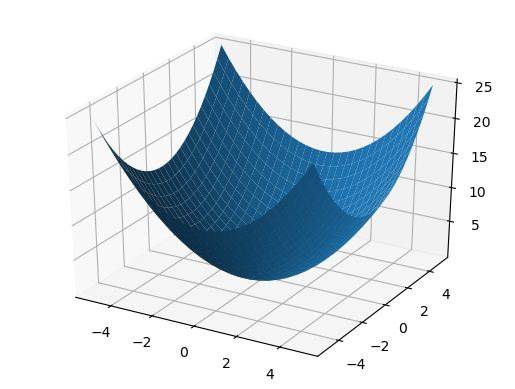

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7fa8462e6a58>

In [32]:
plt.plot_surface(X, Y, reshape(Vpot,(30,30)) )